# Multivariate Gaussian Distributions in AutoEmulate

When building emulator models for expensive simulators, we often need to predict **multivariate outputs**. 
For an input $x$, let the simulator return a $d$-dimensional vector $f(x)\in\mathbb R^d$. 
In practice, we emulate a batch of $n$ inputs simultaneously, collecting:

* **Predictive means**:
  $\mu \;=\; [\,\mu(x_1),\dots,\mu(x_n)\,]^\top \;\in\; \mathbb R^{n d}$

* **Predictive covariance**:

  $$
    \Sigma
    \;=\;
    \begin{bmatrix}
      \Sigma_{11} & \Sigma_{12} & \cdots & \Sigma_{1n} \\
      \Sigma_{21} & \Sigma_{22} & \cdots & \Sigma_{2n} \\
      \vdots      & \vdots      & \ddots & \vdots      \\
      \Sigma_{n1} & \Sigma_{n2} & \cdots & \Sigma_{nn}
    \end{bmatrix}
    \;\in\; \mathbb R^{nd\times nd},
  $$

  where each block $\Sigma_{ij}\in\mathbb R^{d\times d}$ encodes the *cross-covariance* between outputs $f(x_i)$ and $f(x_j)$, and the diagonal $\Sigma_{ii}$ is the *marginal* covariance for input $x_i$.

## Covariance Structures

AutoEmulate provides abstractions to represent and manipulate these structured covariance matrices efficiently, combining flexibility, extensibility, and high performance.
In active learning, three useful covariance-based metrics are provided as instance methods of the classes in the table below: 
`.logdet()` log determinant of covariance, `.trace()` trace of the covariance matrix, `max_eig()` maximum eigenvalue of the covariance matrix (the spectral norm).
All of the covariance matricies of the following classes can be represented as a dense matrix, but, as reported below, we can take advantage of the matrix sparsity to speed up computations.

<center>

| Class           | Description | Representation Shape      | Logdet Complexity | Max Eigen Complexity | Trace Complexity |
| -------------- | ----------- | ------------------------- | ----------------- | -------------------- | ---------------- |
| `Dense`           | Covariance between dimensions and samples. | $(nd, nd)$              | $O((nd)^3)$     | $O((nd)^3)$        | $O((nd)^2)$    |
| `Block_Diagonal` | Only covariance between dimensions, i.e. $\Sigma_{ij} = 0$ for all $i \neq j$. | $(n, d, d)$             | $O(nd^3)$       | $O(nd^3)$          | $O(nd^2)$      |
| `Diagonal`       | Only variance, i.e. $\Sigma_{ij} = 0$ and $\Sigma_{ii}$ is diagonal for all $i\neq j$. | $(n, d)$                | $O(nd)$         | $O(nd)$            | $O(nd)$        |
| `Separable`      | Covariance between samples and dimensions modelled seperately, i.e. $\Sigma = \Sigma_n \otimes \Sigma_d$ | $(n, n)$ and $(d, d)$ | $O(n^3 + d^3)$  | $O(n^3 + d^3)$     | $O(n^2 + d^2)$ |
| `Dirac`          | Represents deterministic point, i.e. $\Sigma = 0$. | N/A                       | N/A               | N/A                  | N/A              |

</center>

These structures satisfy the containment relationships in terms of expressivity:

$$
  \text{Full} \supseteq \text{Block-Diagonal} \supseteq \text{Diagonal},
  \quad
  \text{Full} \supseteq \text{Separable}.
$$

## Ensembles, Empirical Gaussians, and conversions

We also provide an `Ensemble` class, which constructs a `Dense` representation from a set of the above classes. This is useful, for instance, in query-by-committee in active learning, where we query the simulator at inputs $x$ where a measure of disagreement is high. The ensemble mean and covariance are given for $K$ number of Gaussian (of any of the classes above) as:

$$
\mu
= \frac{1}{K}
  \sum_{i=1}^{K}
    \mu_i,
$$
$$
\Sigma
= \frac{1}{K}
  \sum_{i=1}^{K}
    \Sigma_i
+
  \frac{1}{K - 1}
  \sum_{i=1}^{K}
    \bigl(\mu_i - \mu\bigr)
    \bigl(\mu_i - \mu\bigr)^\top.
$$

We can also construct a `Dense` representation from a `(n, d)` batch of samples using the `Empirical` class.

Note that both `Ensemble` and `Empirical` are subclasses of `Dense`. We provide a `.from_dense()` method for each of the non-dense classes in the table above, as well as a `to_dense()` method.
Thus we may do the following for examples:

```python
# Anisotropic empirical distribution from k samples at n sampling locations, each with d dimensions
k, n, d = 1000, 50, 3
samples = torch.rand(k, n, d)
dist0 = Empirical(samples)

# Isotropic empirical distribution (set off-diagonal elements to zero)
samples = torch.rand(k, n, d)
dist1 = Diagonal.from_dense(Empirical(samples))

# Just to demonstrate to the .to_dense() method
dist1 = Diagonal.from_dense(dist1.to_dense())

# We can combine them into an ensemble
dist2 = Ensemble([dist0, dist1])
print(dist2.logdet(), dist2.trace(), dist2.max_eig())
```

which yields

```python
tensor(-375.8140) tensor(12.4797) tensor(0.1201)
```

Below we benchmark the models that can be easily constructed with `.from_dense()`. Note that `Seperable` does not have this method (it only has `.to_dense()`), as the conversion is not bijective.

## Benchmarking

In [6]:
import numpy as np, pandas as pd, time
import matplotlib.pyplot as plt
from autoemulate.experimental.data.gaussian import *
from typing import List
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
k, n, d = 1000, 50, 3
samples = torch.rand(k, n, d)

In [8]:
def compare(classes: List[Structured], n_runs: int, n_list: List[int], d_list: List[int], k: int) -> pd.DataFrame:

    # For timing and comparison
    def compare(f_struct, f_dense):
        t0 = time.perf_counter()
        r0 = float(f_struct())
        t1 = time.perf_counter()
        r1 = float(f_dense())
        t2 = time.perf_counter()
        T_struct, T_dense = t1 - t0, t2 - t1
        return T_struct, T_dense, r0, r1
    
    # Results
    results = []
    for cls in classes:
        for n in n_list:
            for d in d_list:
                for _ in range(n_runs):
                    # Generate random samples
                    samples = torch.rand(k, n, d)
                    dist_struct = cls.from_dense(Empirical(samples))
                    dist_dense = dist_struct.to_dense()
                    for f_struct, f_dense in zip(
                        [dist_struct.logdet, dist_struct.trace, dist_struct.max_eig],
                        [dist_dense.logdet, dist_dense.trace, dist_dense.max_eig]
                    ):
                        T_struct, T_dense, r0, r1 = compare(f_struct, f_dense)
                        results.append({
                            "Type": cls.__name__,
                            "Function": f_struct.__name__,
                            "Dense time": T_dense * 1e6,
                            "Structured time": T_struct * 1e6,
                            "Dense result": r0,
                            "Structured result": r1,
                            "Size": n * d
                        })
    return pd.DataFrame(results)

In [9]:
def plot_results(results, typ, function, metric, ax=None):
    sub = (
        results[(results["Type"] == typ) & (results["Function"] == function)]
        .groupby("Size")[metric]
        .agg(mean="mean", std="std")
        .reset_index()
    )
    if ax is None:
        fig, ax = plt.subplots()
    # draw onto the explicit Axes object
    ax.plot(sub["Size"], sub["mean"],
            label=metric, marker="o", linestyle="-")
    ax.fill_between(
        sub["Size"],
        sub["mean"] - sub["std"],
        sub["mean"] + sub["std"],
        alpha=0.2,
    )
    return ax

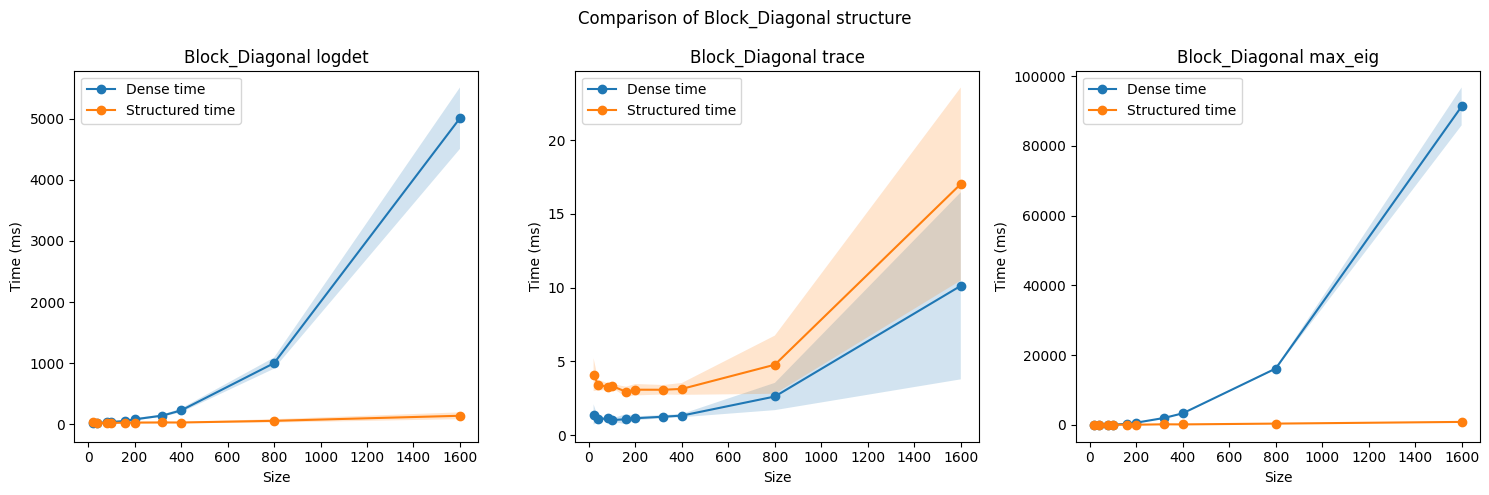

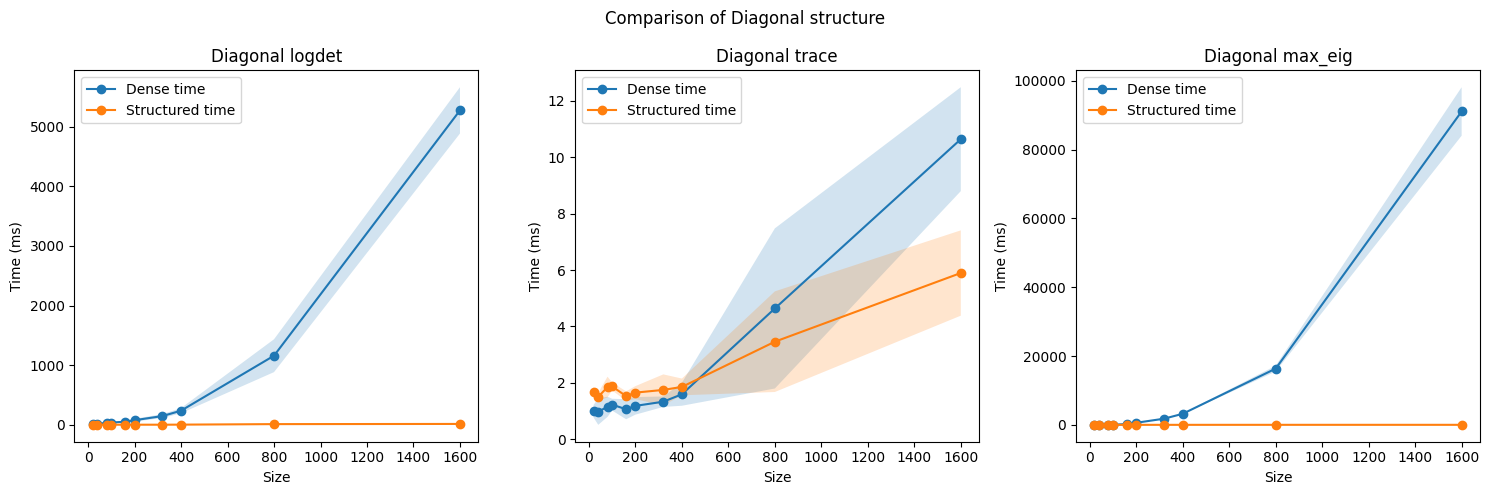

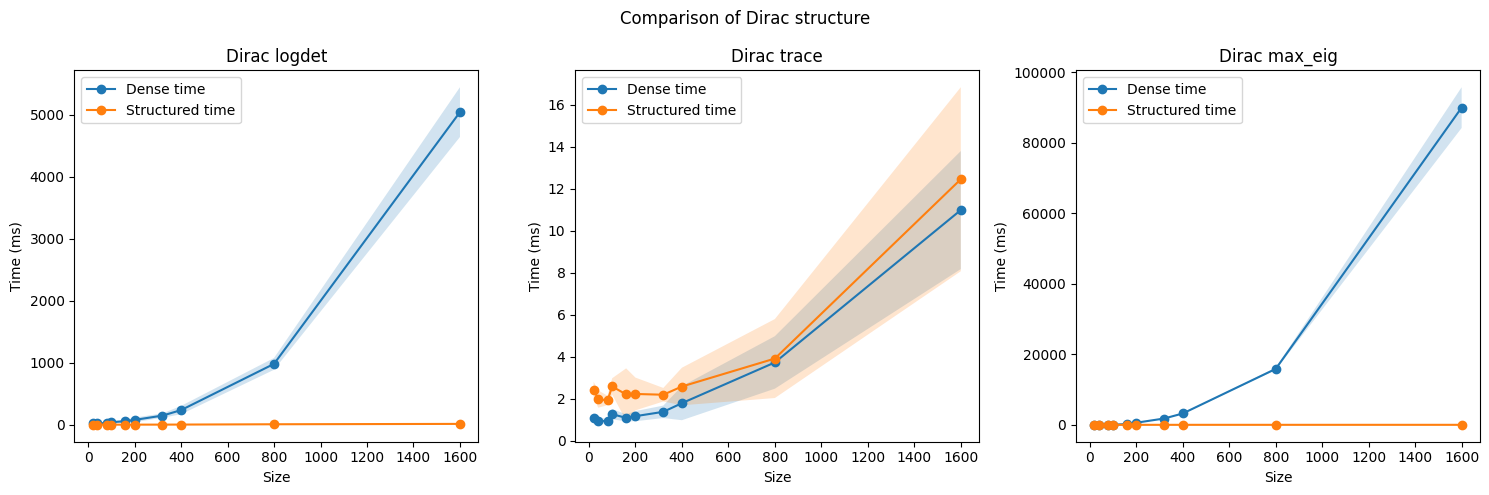

In [10]:
results = compare(
    classes=[
        Block_Diagonal,
        Diagonal,
        Dirac,
    ],
    n_runs=100,
    n_list=[10, 20, 50, 100],
    d_list=[2, 4, 8, 16],
    k=100
)
for t in ["Block_Diagonal", "Diagonal", "Dirac"]:
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Comparison of {t} structure")
    for i, f in enumerate(["logdet", "trace", "max_eig"]):
        plt.sca(ax[i])  # ← make ax[i] current
        plot_results(results, t, f, "Dense time", ax=ax[i])
        plot_results(results, t, f, "Structured time", ax=ax[i])
        ax[i].set_title(f"{t} {f}")
        ax[i].set_xlabel("Size")
        ax[i].set_ylabel("Time (ms)")
        ax[i].legend()
    plt.tight_layout()
    plt.show()